In [168]:
# LangChain
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain.graphs import Neo4jGraph
from langchain_core.tools import tool

# LangGraph
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# General Imports
import os
import ast
import operator
from pathlib import Path
from dotenv import load_dotenv
from typing import TypedDict, Annotated # to construct the agent's state
from IPython.display import Image, display

# Connect to graph
dotenv_path = Path('./.env')
load_dotenv(dotenv_path=dotenv_path)
os.environ["NEO4J_URI"] = os.getenv('uri')
os.environ["NEO4J_USERNAME"] = os.getenv('user_name')
os.environ["NEO4J_PASSWORD"] = os.getenv('password')
graph = Neo4jGraph()

# Create the tool to be used by the Agent
@tool
def query_graph(query):
  """Query from Neo4j knowledge graph using Cypher."""
  return graph.query(query)


# Create Agent's State
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    tool_messages: Annotated[list[AnyMessage], operator.add]
    cypher_query_and_outputs: Annotated[list[dict], operator.add]

# Create Agent
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        self.tools = {t.name: t for t in tools} # Save the tools' names that can be used
        self.model = model.bind_tools(tools) # Provide the name of the tools to the agent

        graph = StateGraph(AgentState) # initialize a stateful graph
        memory = MemorySaver()

        graph.add_node("personality_scientist", self.call_groq) # Add LLM node
        graph.add_node("toolbox", self.use_tool) # Search in tools and use the tools provided
        graph.add_node("structure_queried_data", self.structure_queried_data)

        # The edge where the decision to use a tool is made
        graph.add_conditional_edges("personality_scientist", self.validate_action, {True: "toolbox", False: END})
        
        # Create edge and set starting point of the graph
        graph.add_edge("toolbox", "structure_queried_data")
        graph.add_edge("structure_queried_data", END)
        graph.set_entry_point("personality_scientist")

        self.graph = graph.compile(checkpointer=memory) # Build graph
        display(Image(self.graph.get_graph().draw_mermaid_png()))

    # Get the LLM's response and update the Agent's State by adding the response to the messages
    def call_groq(self, state: AgentState):
        messages = state['messages']
        if self.system: messages = [SystemMessage(content=self.system)] + messages
        
        message = self.model.invoke(messages)
        return {'messages': [message]}
    
    # Check if an action exists by checking the last message in the state which is supposed to contain the tool's info
    def validate_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    # Search for the tool and use it
    def use_tool(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for tool in tool_calls:
            print(f"Calling: {tool}")
            
            # If tool not found
            if not tool['name'] in self.tools: 
                print("\n ....tool name not found in list of tools....")
                result = "tool name not found in list of tools, retry"  # instruct LLM to retry
            
            # If tool exists, use it
            else:
                result = self.tools[tool['name']].invoke(tool['args']) 

            # Save the message returned from the tool
            results.append(ToolMessage(tool_call_id=tool['id'], name=tool['name'], content=str(result)))

        print("Back to the model!")
        return {'tool_messages': results}
    

    def structure_queried_data(self, state: AgentState):
        
        query_output = state['tool_messages'][-1].content
        cypher_code = ast.literal_eval(state['messages'][-1].additional_kwargs['tool_calls'][0]['function']['arguments'])['query']
        structured_output = {'cypher_code': cypher_code, 'output': query_output}
         
        return {'cypher_query_and_outputs': [structured_output]}

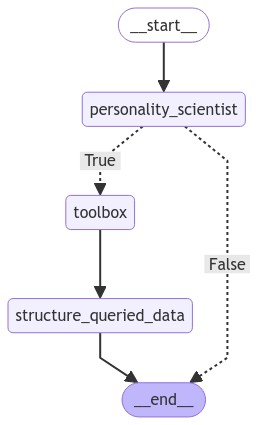

In [169]:
from langchain_groq import ChatGroq
from prompts import prompt

model = ChatGroq(temperature=0.8, groq_api_key=os.environ["GROQ_API_KEY"], model_name="llama-3.1-70b-versatile")

agent = Agent(model=model, tools=[query_graph], system=prompt.format(schema=graph.structured_schema))

In [162]:
thread = {'configurable': {'thread_id': "1"}}

output = agent.graph.stream({"messages": [HumanMessage(content="b")]}, thread, stream_mode='values')

for message in output:
    message['messages'][-1].pretty_print()

================================ Human Message =================================

b
================================== Ai Message ==================================
Tool Calls:
  query_graph (call_vxhm)
 Call ID: call_vxhm
  Args:
    query: MATCH (n:Occupation)-[]->(m:Personality_Trait) return n,m
Calling: {'name': 'query_graph', 'args': {'query': 'MATCH (n:Occupation)-[]->(m:Personality_Trait) return n,m'}, 'id': 'call_vxhm', 'type': 'tool_call'}
Back to the model!
================================== Ai Message ==================================
Tool Calls:
  query_graph (call_vxhm)
 Call ID: call_vxhm
  Args:
    query: MATCH (n:Occupation)-[]->(m:Personality_Trait) return n,m
================================== Ai Message ==================================
Tool Calls:
  query_graph (call_vxhm)
 Call ID: call_vxhm
  Args:
    query: MATCH (n:Occupation)-[]->(m:Personality_Trait) return n,m


In [167]:
# query_output = ast.literal_eval(agent.graph.get_state(thread).values['messages'][-2].content)
# llm_query = ast.literal_eval(agent.graph.get_state(thread).values['messages'][-3].additional_kwargs['tool_calls'][0]['function']['arguments'])['query']

# structured_output = {llm_query: query_output}
# structured_output

# agent.graph.get_state(thread).values['messages']
# agent.graph.get_state(thread).values['tool_messages']
agent.graph.get_state(thread).values['cypher_query_and_outputs'][0]['output'].content

"[{'n': {'title': 'Occupational_Therapy_Aides'}, 'm': {'title': 'Conventional'}}, {'n': {'title': 'Nursing_Assistants'}, 'm': {'title': 'Conventional'}}, {'n': {'title': 'Licensed_Practical_and_Licensed_Vocational_Nurses'}, 'm': {'title': 'Conventional'}}, {'n': {'title': 'Hearing_Aid_Specialists'}, 'm': {'title': 'Conventional'}}, {'n': {'title': 'Dietetic_Technicians'}, 'm': {'title': 'Conventional'}}, {'n': {'title': 'Concierges'}, 'm': {'title': 'Conventional'}}, {'n': {'title': 'Shampooers'}, 'm': {'title': 'Conventional'}}, {'n': {'title': 'Passenger_Attendants'}, 'm': {'title': 'Conventional'}}, {'n': {'title': 'Medical_Secretaries_and_Administrative_Assistants'}, 'm': {'title': 'Conventional'}}, {'n': {'title': 'Lifeguards,_Ski_Patrol,_and_Other_Recreational_Protective_Service_Workers'}, 'm': {'title': 'Conventional'}}, {'n': {'title': 'Hotel,_Motel,_and_Resort_Desk_Clerks'}, 'm': {'title': 'Conventional'}}, {'n': {'title': 'Funeral_Attendants'}, 'm': {'title': 'Conventional'}}

In [ ]:
def extract_labels_from_query(cypher_code):
  # Extract start index and end index of the labels ex: (n:Occupation)
  start = []
  end = []
  for i, character in enumerate(cypher_code):
    if character == "(": start.append(i+1)
    if character == ")": end.append(i)

  # Extract the labels using the start and end indicies. return labels as {'n': 'Occupation'...}
  labels = {}
  for i in range(len(start)):
    label = cypher_code[start[i]: end[i]]
    label = label.split(":")

    labels[label[0]] = label[1]

  return labels

## Order the data automatically and then give the output to the model. the model then extracts suitable traits.
## save the cypher_code + query results + version of extraction.
## this way, if the model queries a similar query to before, it doesnt send it, it uses the pre-outputted results.
def organize_queried_data(data, labels):
  structured_queried_data = {'relations': []}

  for i in range(len(data)):
    # extract keys (nodes' refrences as they were returned from the query output. ex: return n,m)
    row = data[i]
    keys = list(row.keys()) # keys are the referenced labels. ex: n:Occupation, so n is referencing Occupation
    # Extract graph properties

    # print("---")
    relation = []
    for i in range(len(keys)):
      key = keys[i]

      label = labels[key]
      properties = row[key]

      relation.append({label: properties})

    structured_queried_data['relations'] += [relation]
  
  return structured_queried_data

labels = extract_labels_from_query(cypher_code=llm_query)
organize_queried_data(data=query_output, labels=labels)['relations']